# Using XGBClassifier to predict survivors of the Titanic.

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split


In [2]:
# Load the data
train_df = pd.read_csv('train.csv', header=0)
test_df = pd.read_csv('test.csv', header=0) 
print('Train:')
print(train_df.tail())
print()
print('Test:')
print(test_df.tail())

Train:
     PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q  

Test:
     PassengerId  Pclass                          Name     Sex   Age  SibSp  \
413         1305  

# Note that the test data does not have the survived column.

In [3]:
# We'll impute missing values using the median for numeric columns and the most
# common value for string columns.
# This is based on some nice code by 'sveitser' at http://stackoverflow.com/a/25562948
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [4]:
feature_columns_to_use = ['Pclass','Sex','Age','Fare','Parch']
nonnumeric_columns = ['Sex']

In [5]:
# Join the features from train and test together before imputing missing values,
# in case their distribution is slightly different
big_X = train_df[feature_columns_to_use].append(test_df[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)

In [6]:
# XGBoost doesn't (yet) handle categorical features automatically, so we need to change
# them to columns of integer values.
# See http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing for more
# details and options
le = LabelEncoder()
for feature in nonnumeric_columns:
    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

In [7]:
print(big_X.shape)
big_X.tail()

(1309, 5)


,Pclass,Sex,Age,Fare,Parch
413,3,male,NaN,8.0500,0
414,1,female,39.0,108.9000,0
415,3,male,38.5,7.2500,0
416,3,male,NaN,8.0500,0
417,3,male,NaN,22.3583,1


In [8]:
print(big_X_imputed.shape)
big_X_imputed.tail()

(1309, 5)


,Pclass,Sex,Age,Fare,Parch
413,3,1,28.0,8.0500,0
414,1,0,39.0,108.9000,0
415,3,1,38.5,7.2500,0
416,3,1,28.0,8.0500,0
417,3,1,28.0,22.3583,1


In [9]:
# Prepare the inputs for the model
# train_df.shape[0] is 891. So... 
# train_X = big_X_imputed[0:891].values
train_X = big_X_imputed[0:train_df.shape[0]].values
train_y = train_df['Survived']

# train.df.shape[0] is 891, so set test equal to the rest of the df....
# test_X = big_X_imputed[891::]
test_X = big_X_imputed[train_df.shape[0]::].values

In [10]:
print('tail of train_X (values from big_X_imputed)')
print(train_X[-5:])
print('shape: ', train_X.shape)
print()

print('tail of train_y:')
print(train_y[-5:])
print('shape: ', train_y.shape)
print()

print('tail of test_X:')
print(test_X[-5:])
print('shape: ', test_X.shape)
print()

print('There is no "Survived" column in the test data as this is a contest and they did not want to disclose that.')
print('So we will not be able to calculate any accuracy stats on the predicted test data.')
print(test_df.columns)

tail of train_X (values from big_X_imputed)
[[ 2.    1.   27.   13.    0.  ]
 [ 1.    0.   19.   30.    0.  ]
 [ 3.    0.   28.   23.45  2.  ]
 [ 1.    1.   26.   30.    0.  ]
 [ 3.    1.   32.    7.75  0.  ]]
shape:  (891, 5)

tail of train_y:
886    0
887    1
888    0
889    1
890    0
Name: Survived, dtype: int64
shape:  (891,)

tail of test_X:
[[  3.       1.      28.       8.05     0.    ]
 [  1.       0.      39.     108.9      0.    ]
 [  3.       1.      38.5      7.25     0.    ]
 [  3.       1.      28.       8.05     0.    ]
 [  3.       1.      28.      22.3583   1.    ]]
shape:  (418, 5)

There is no "Survived" column in the test data as this is a contest and they did not want to disclose that.
So we will not be able to calculate any accuracy stats on the predicted test data.
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [11]:
# You can experiment with many other options here, using the same .fit() and .predict()
# methods; see http://scikit-learn.org
# This example uses the current build of XGBoost, from https://github.com/dmlc/xgboost
xgb_model = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)
train_pred = xgb_model.predict(train_X)
predictions = xgb_model.predict(test_X)

In [12]:
print('original big_X_imputed:')
print(big_X_imputed[-10:])
print('shape:', big_X_imputed.shape)
print()

print('train_X (which has the values of the big_X_imputed):')
print(train_X[-10:])
print('shape:', train_X.shape)
print()

print('train_y:')
print(train_y[-10:])
print('shape:', train_y.shape)
print()

print('test_X:')
print(test_X[-10:])
print('shape:', test_X.shape)
print()

print('train_pred:')
print(train_pred[-10:])
print('shape:', train_pred.shape)
print()

print('predictions:')
print(predictions[-10:])
print('shape:', predictions.shape)

original big_X_imputed:
     Pclass  Sex   Age      Fare  Parch
408       3    0  28.0    7.7208      0
409       3    0   3.0   13.7750      1
410       3    0  28.0    7.7500      0
411       1    0  37.0   90.0000      0
412       3    0  28.0    7.7750      0
413       3    1  28.0    8.0500      0
414       1    0  39.0  108.9000      0
415       3    1  38.5    7.2500      0
416       3    1  28.0    8.0500      0
417       3    1  28.0   22.3583      1
shape: (1309, 5)

train_X (which has the values of the big_X_imputed):
[[ 3.      1.     33.      7.8958  0.    ]
 [ 3.      0.     22.     10.5167  0.    ]
 [ 2.      1.     28.     10.5     0.    ]
 [ 3.      1.     25.      7.05    0.    ]
 [ 3.      0.     39.     29.125   5.    ]
 [ 2.      1.     27.     13.      0.    ]
 [ 1.      0.     19.     30.      0.    ]
 [ 3.      0.     28.     23.45    2.    ]
 [ 1.      1.     26.     30.      0.    ]
 [ 3.      1.     32.      7.75    0.    ]]
shape: (891, 5)

train_y:
881    0

In [13]:
accuracy = accuracy_score(train_y, train_pred)
print("Accuracy on Training Data: %.2f%%" % (accuracy * 100.0))

Accuracy on Training Data: 88.66%


In [14]:
confusion_df = pd.DataFrame(confusion_matrix(train_y, train_pred),
             columns=['Predicted to Die', 'Predicted to Survive'], index=['Actual Died', 'Actual Survived'])

confusion_df

,Predicted to Die,Predicted to Survive
Actual Died,516,33
Actual Survived,68,274


In [15]:
print(classification_report(train_y, train_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       549
           1       0.89      0.80      0.84       342

    accuracy                           0.89       891
   macro avg       0.89      0.87      0.88       891
weighted avg       0.89      0.89      0.89       891



# change feature names back from f0 to Pclass, etc.

In [16]:
dtrain = xgb.DMatrix(train_X)
dtrain.feature_names = ['Pclass', 'Sex', 'Age', 'Fare', 'Parch']
dtrain.feature_names

['Pclass', 'Sex', 'Age', 'Fare', 'Parch']

# Plot feature importance.

In [17]:
xgb_model.get_booster().get_score()
mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
mapped = {mapper[k]: v for k, v in xgb_model.get_booster().get_score().items()}
mapped

{'Sex': 98, 'Pclass': 160, 'Fare': 833, 'Age': 567, 'Parch': 21}

# Documentation notes:
# xgboost.plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, grid=True, show_values=True, **kwargs)

Plot importance based on fitted trees.

Parameters
- booster (Booster, XGBModel or dict) – Booster or XGBModel instance, or dict taken by Booster.get_fscore()

- ax (matplotlib Axes, default None) – Target axes instance. If None, new figure and axes will be created.

- grid (bool, Turn the axes grids on or off. Default is True (On)) –


- importance_type (str, default "weight") - How the importance is calculated: either “weight”, “gain”, or “cover”
    - ”weight” is the number of times a feature appears in a tree
    - ”gain” is the average gain of splits which use the feature
    - ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split


- max_num_features (int, default None) – Maximum number of top features displayed on plot. If None, all features will be displayed.

- height (float, default 0.2) – Bar height, passed to ax.barh()

- xlim (tuple, default None) – Tuple passed to axes.xlim()

- ylim (tuple, default None) – Tuple passed to axes.ylim()

- title (str, default "Feature importance") – Axes title. To disable, pass None.

- xlabel (str, default "F score") – X axis title label. To disable, pass None.

- ylabel (str, default "Features") – Y axis title label. To disable, pass None.

- show_values (bool, default True) – Show values on plot. To disable, pass False.

- kwargs – Other keywords passed to ax.barh()

Text(0.5, 0, 'f-score')

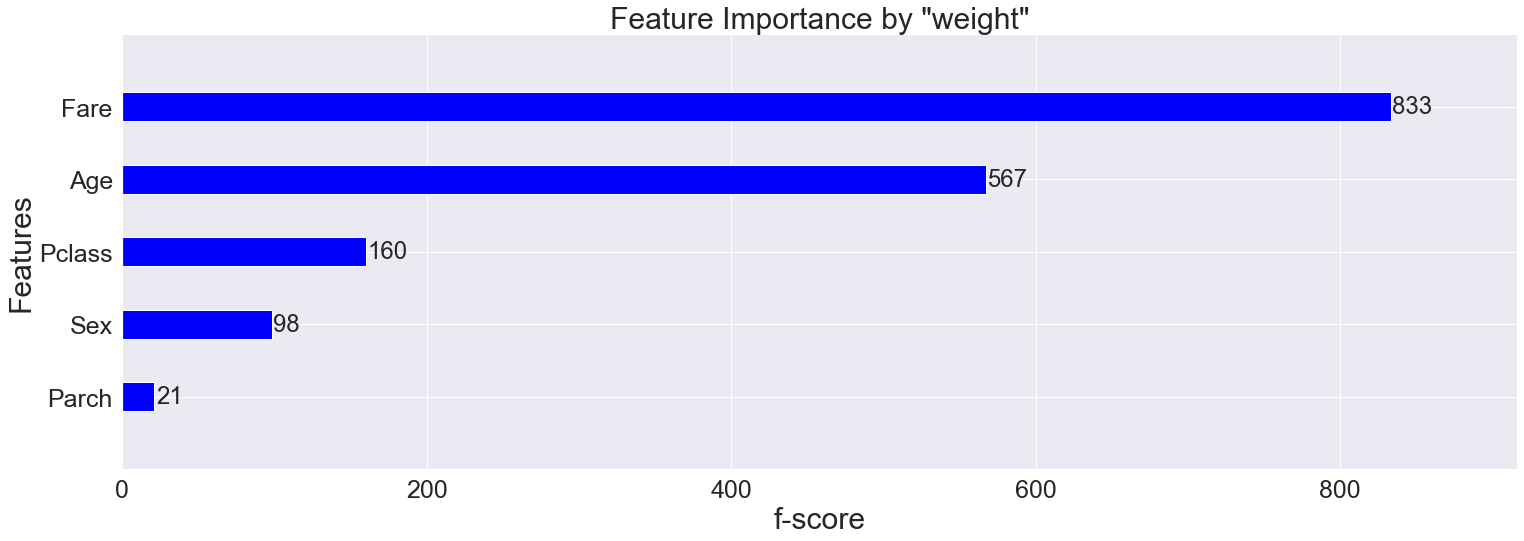

In [18]:
# set size of all fonts (but after specifying the ones at the bottom, this will only apply to the f-scores)
import seaborn as sns
sns.set(font_scale = 2)

# set size of chart
fig, ax = plt.subplots(figsize=(25,8))

# create chart using useful parameters
xgb.plot_importance(mapped, ax=ax, color='blue', height=0.4, # importance_type='weight', (doesn't change value)
                    max_num_features=None, grid=True, show_values=True)

# need to use the following (rather than parameters) in order to set fontsize for these 
# as different than the font_scale
plt.title('Feature Importance by "weight"', fontsize = 30)
plt.yticks(fontsize = 25)
plt.ylabel('Features', fontsize = 30)
plt.xticks(fontsize = 25)
plt.xlabel('f-score', fontsize = 30)

This was simpler code to get the same chart, but the features were labeled f0, f1, etc.

In [19]:
# plt.rcParams["figure.figsize"] = (25, 8)
# xgb.plot_importance(xgb_model, color='blue')
# plt.title('importance', fontsize = 20)
# plt.yticks(fontsize = 10)
# plt.ylabel('features', fontsize = 20)

# plot the output tree, use to_graphviz to increase size

In [20]:
# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model, num_trees=xgb_model.get_booster().best_iteration)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [21]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Parch']
for n in range(5):
    print('for', features[n], ':')
    print('   ', sp.stats.ttest_ind(
                    train_X[train_y == 1][n],
                    train_X[train_y == 0][n]))
    print()

for Pclass :
    Ttest_indResult(statistic=1.0364488034956714, pvalue=0.33030296023854366)

for Sex :
    Ttest_indResult(statistic=-0.24811849671940617, pvalue=0.8102928875853096)

for Age :
    Ttest_indResult(statistic=0.7948435821626529, pvalue=0.44964000977142293)

for Fare :
    Ttest_indResult(statistic=-0.9423310129190284, pvalue=0.37360508669249026)

for Parch :
    Ttest_indResult(statistic=0.513834505232151, pvalue=0.6212554523998743)



So none of these features in themselves have means that differ significantly between those that survived and those that died.

In [22]:
# Kaggle needs the submission to have a certain format;
# see https://www.kaggle.com/c/titanic-gettingStarted/download/gendermodel.csv
# for an example of what it's supposed to look like.
submission = pd.DataFrame({ 'PassengerId': test_df['PassengerId'],
                            'Survived': predictions })
submission.to_csv("submission.csv", index=False)

In [23]:
submission.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
